<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/began.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[BEGAN: Boundary Equilibrium Generative
Adversarial Networks](https://arxiv.org/pdf/1703.10717.pdf)

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm

In [13]:
n_epochs = 200
b1 = 0.5
b2 = 0.999
lr = 0.0002
batch_size = 64
latent_dim = 62
img_size = 32
display_step = 5000
channels = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
img_shape = (channels,img_size,img_size)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim,128 * self.init_size **2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128,0.8),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,64,3,1,1),
            nn.BatchNorm2d(64,0.8),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Conv2d(64,channels,3,1,1),
            nn.Tanh()
        )
    def forward(self,z):
        out = self.l1(z)
        out = out.view(out.size(0),128,self.init_size,self.init_size)
        img = self.conv_blocks(out)
        return img

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        #downsampling
        self.down = nn.Sequential(nn.Conv2d(channels,64,3,2,1),nn.ReLU())

        #fully connected layers
        self.down_size = img_size // 2
        down_dim = 64 * self.down_size ** 2
        self.fc = nn.Sequential(
            nn.Linear(down_dim, 32),
            nn.BatchNorm1d(32,0.8),
            nn.ReLU(inplace = True),
            nn.Linear(32,down_dim),
            nn.BatchNorm1d(down_dim),
            nn.ReLU(inplace = True)
        )
        #upsampling
        self.up = nn.Sequential(nn.Upsample(scale_factor = 2),nn.Conv2d(64,channels,3,1,1))
    def forward(self,img):
        out = self.down(img)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        out = out.view(out.size(0),64,self.down_size,self.down_size)
        out = self.up(out)
        return out

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

def weights_init_normal(m : nn.Module):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0.0)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(),lr = lr,betas = (b1,b2))
optimizer_D  = torch.optim.Adam(discriminator.parameters(), lr = lr ,betas = (b1,b2))

In [17]:
dataloader = DataLoader(
    datasets.MNIST(
        '.root',
        train = True,
        download= True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle  = True
)

In [18]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

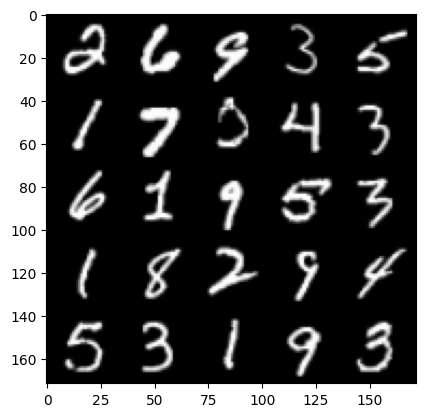

In [19]:
images,labels = next(iter(dataloader))
show_tensor_images(images)

BEGAN hyper parameters

In [20]:
gamma = 0.75
lambda_k = 0.001
k = 0.0

 33%|███▎      | 309/938 [00:12<00:24, 25.23it/s]

Epoch 5, step 5000: G loss: 0.07071043777465805, dloss: 0.09505911548435685, M :0.09063635766506195,k:0.055218395613134144


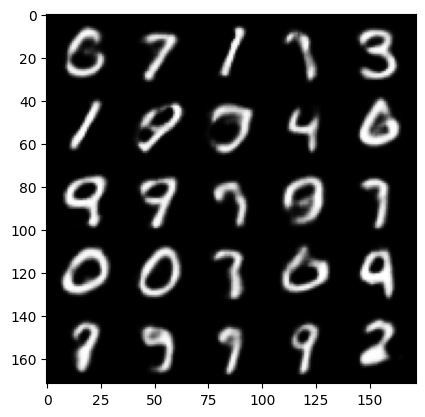

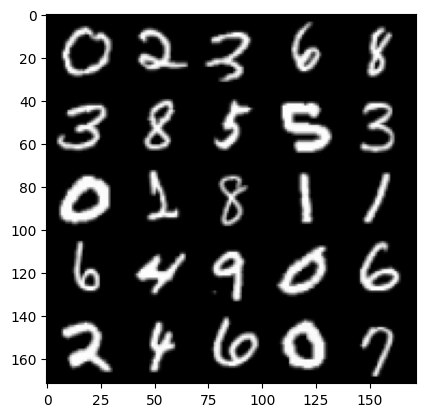

 66%|██████▌   | 620/938 [00:25<00:12, 24.66it/s]

Epoch 10, step 10000: G loss: 0.06463086644560095, dloss: 0.08602356498688436, M :0.09023775160312653,k:0.06987603934854313


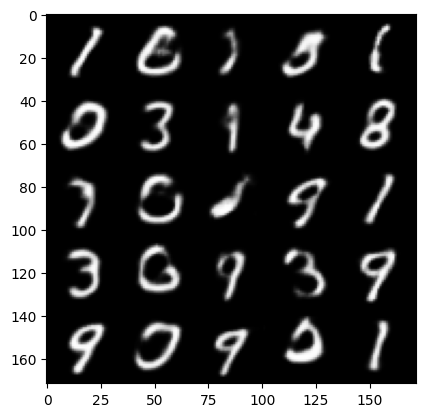

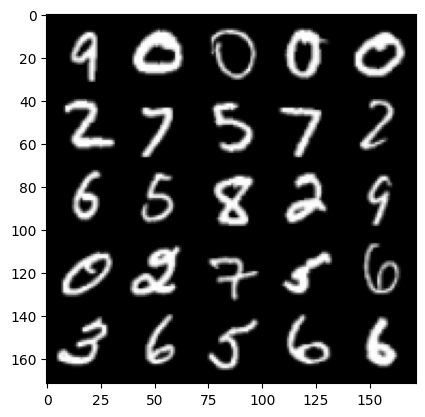

 99%|█████████▉| 928/938 [00:38<00:00, 20.96it/s]

Epoch 15, step 15000: G loss: 0.0618594368219376, dloss: 0.08060914699733253, M :0.0826079398393631,k:0.08035225860774543


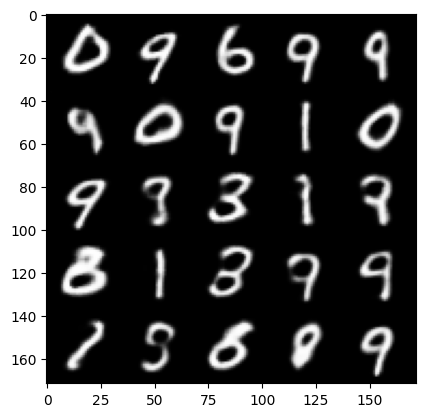

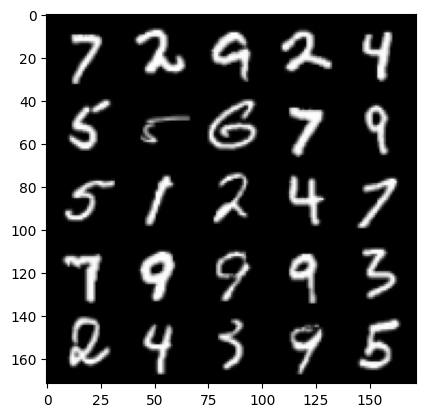

 32%|███▏      | 302/938 [00:12<00:29, 21.44it/s]

Epoch 21, step 20000: G loss: 0.060092560869455344, dloss: 0.07702415413260463, M :0.08727476000785828,k:0.08766709455847772


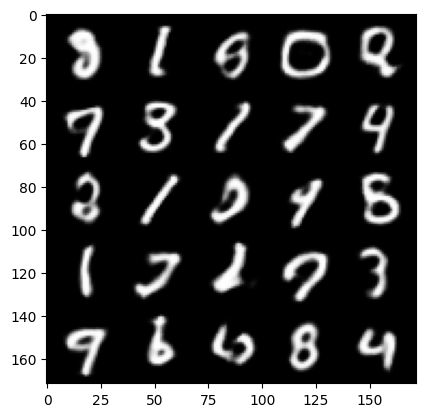

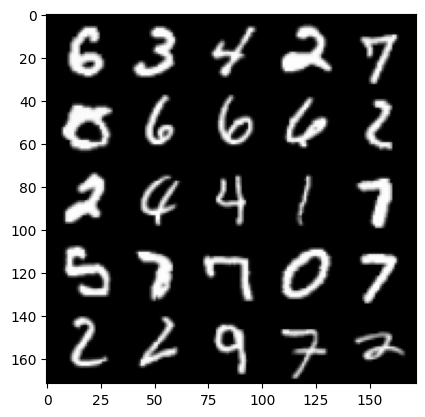

 65%|██████▌   | 612/938 [00:26<00:15, 20.64it/s]

Epoch 26, step 25000: G loss: 0.058424575593322516, dloss: 0.07443883615732201, M :0.08333851397037506,k:0.09466723048314446


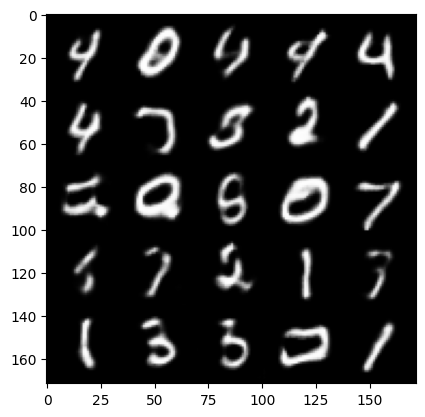

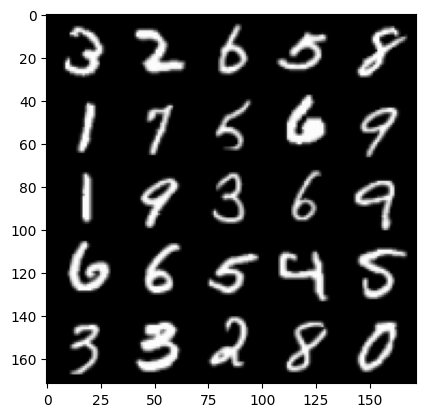

 98%|█████████▊| 922/938 [00:39<00:00, 19.72it/s]

Epoch 31, step 30000: G loss: 0.05739370446950193, dloss: 0.07245561281740648, M :0.08486342430114746,k:0.10042303237691551


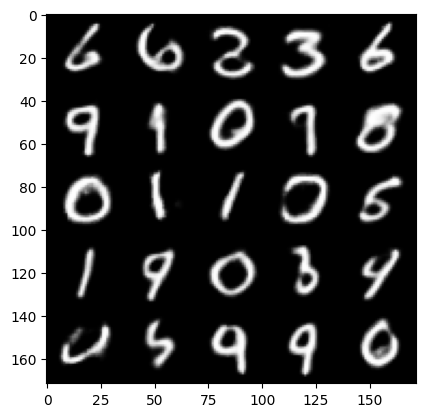

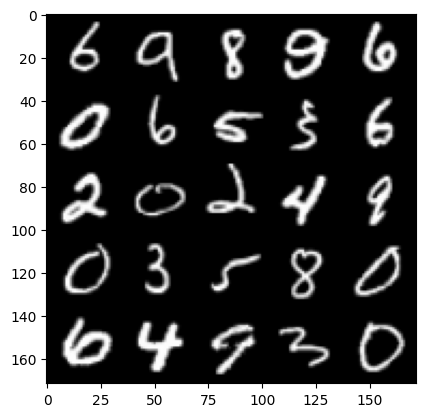

 31%|███       | 293/938 [00:12<00:30, 20.95it/s]

Epoch 37, step 35000: G loss: 0.05643309523910272, dloss: 0.07084220798909659, M :0.07599367201328278,k:0.10573005234450125


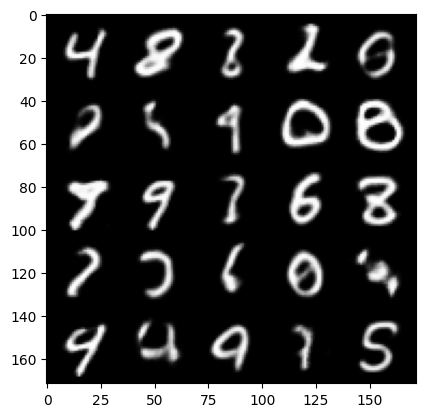

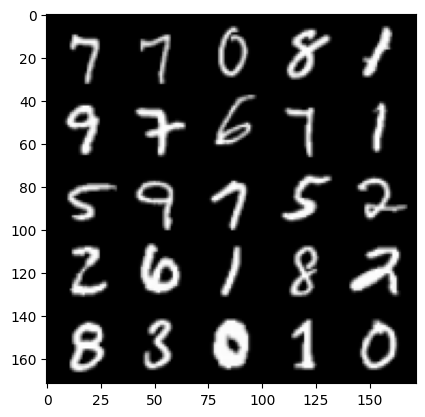

 64%|██████▍   | 602/938 [00:26<00:18, 18.43it/s]

Epoch 42, step 40000: G loss: 0.055826348820328754, dloss: 0.06955125377178198, M :0.07337406277656555,k:0.11001264255493896


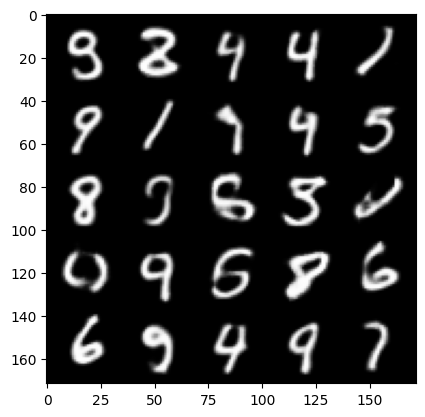

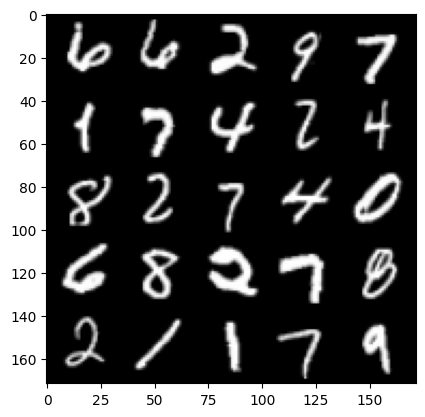

 97%|█████████▋| 913/938 [00:39<00:01, 23.86it/s]

Epoch 47, step 45000: G loss: 0.05520110546052455, dloss: 0.06834471022933732, M :0.07791252434253693,k:0.11345311404764666


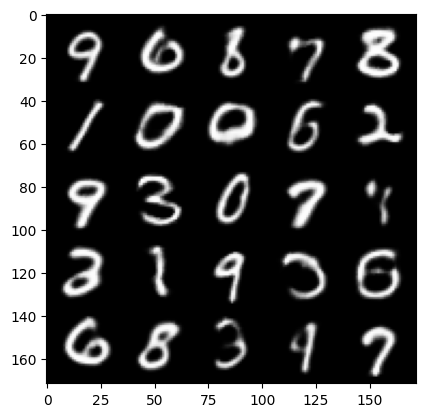

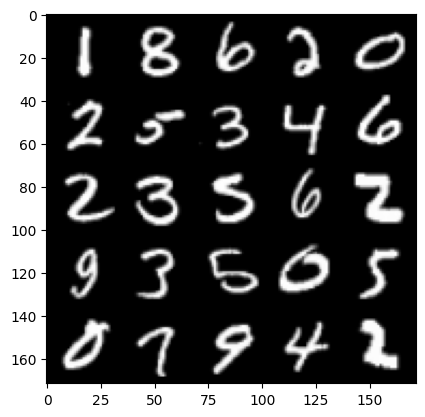

 30%|███       | 285/938 [00:12<00:26, 24.29it/s]

Epoch 53, step 50000: G loss: 0.05465767404437048, dloss: 0.0673235801123083, M :0.07338431477546692,k:0.11617607897892597


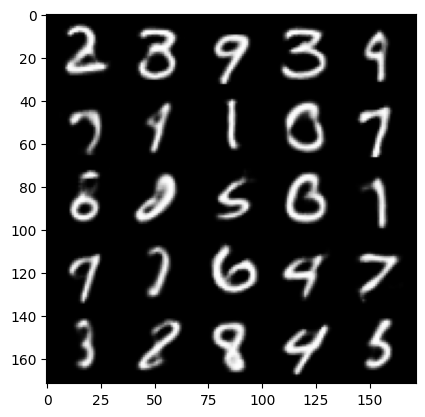

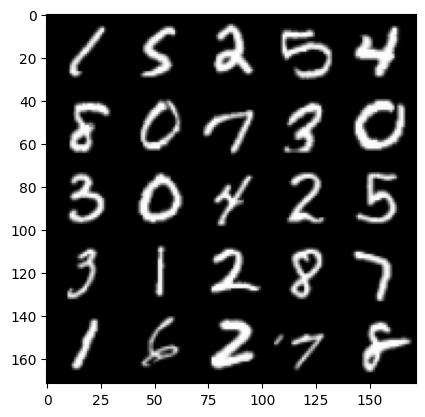

 63%|██████▎   | 594/938 [00:25<00:14, 24.26it/s]

Epoch 58, step 55000: G loss: 0.054237720896303666, dloss: 0.06654514422938218, M :0.07262923568487167,k:0.11840895209833993


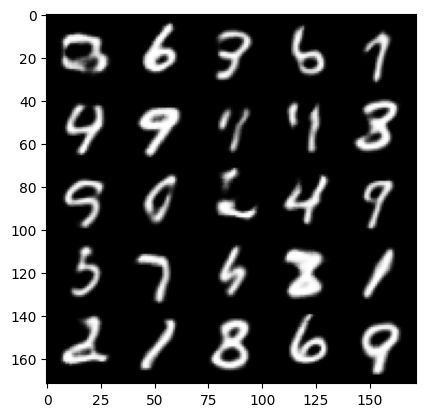

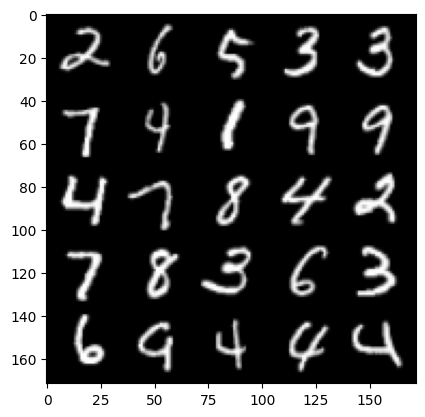

 96%|█████████▋| 904/938 [00:38<00:01, 23.94it/s]

Epoch 63, step 60000: G loss: 0.05379316701889043, dloss: 0.06576965520605443, M :0.07193809747695923,k:0.12014371646195675


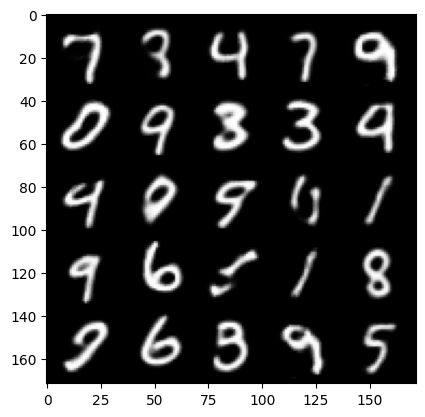

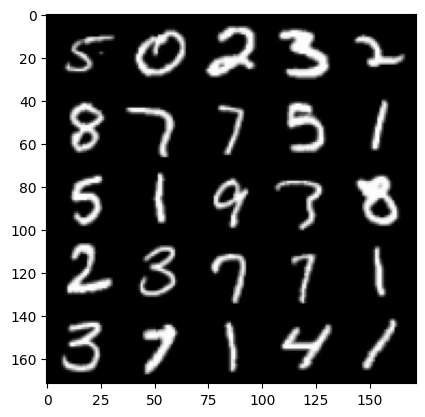

 30%|██▉       | 278/938 [00:11<00:26, 24.54it/s]

Epoch 69, step 65000: G loss: 0.0534605975821614, dloss: 0.06506372102126472, M :0.0746583342552185,k:0.12101379865407959


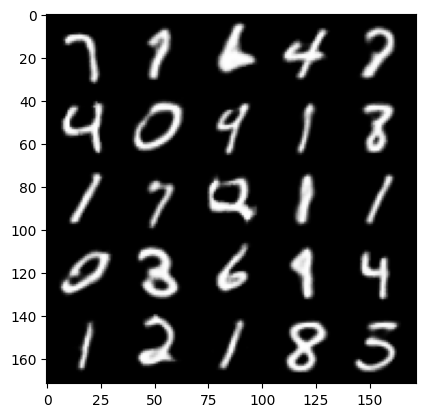

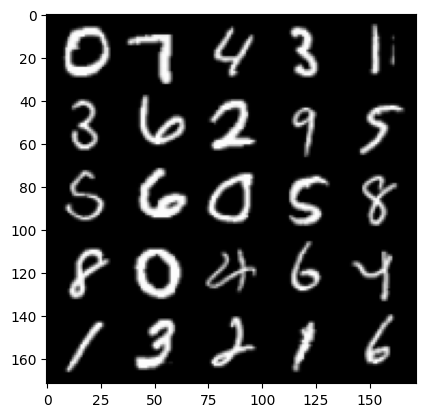

 63%|██████▎   | 588/938 [00:25<00:14, 23.35it/s]

Epoch 74, step 70000: G loss: 0.05296014129519466, dloss: 0.06439558084756154, M :0.07631734758615494,k:0.12182189670577681


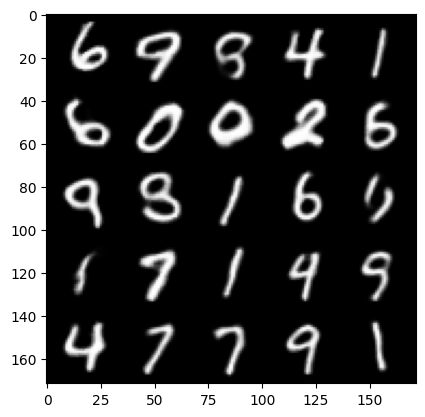

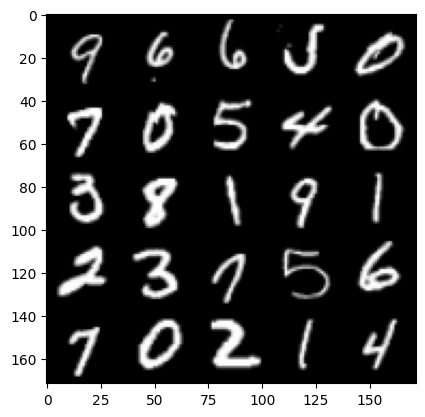

 96%|█████████▌| 897/938 [00:38<00:02, 19.30it/s]

Epoch 79, step 75000: G loss: 0.052632365304231515, dloss: 0.06384807264655834, M :0.07019355893135071,k:0.12217853933572827


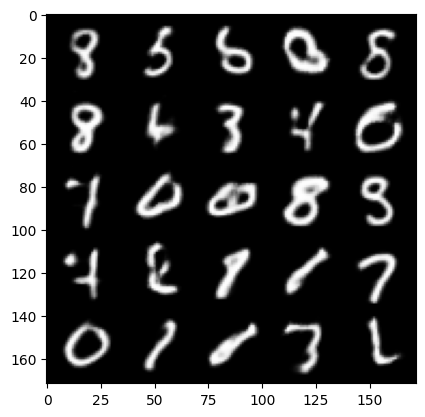

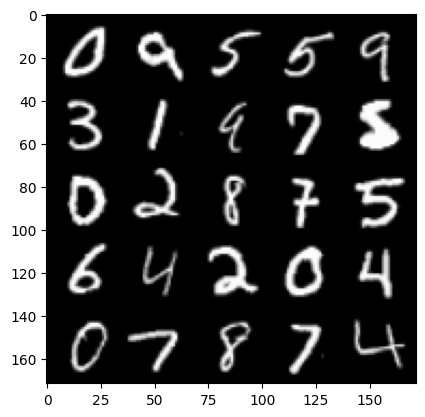

 29%|██▉       | 270/938 [00:11<00:27, 24.14it/s]

Epoch 85, step 80000: G loss: 0.05231957299932823, dloss: 0.06329370811954145, M :0.07880166918039322,k:0.1218853739611813


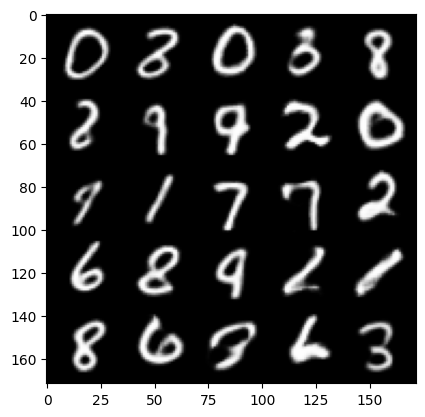

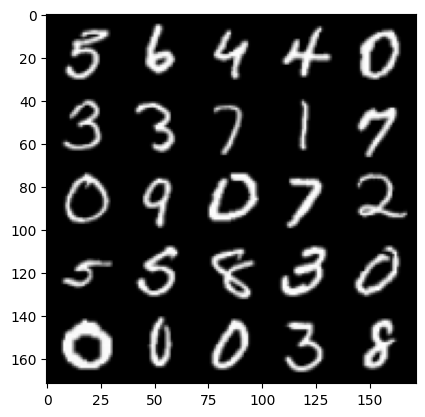

 62%|██████▏   | 579/938 [00:24<00:14, 23.97it/s]

Epoch 90, step 85000: G loss: 0.05211928909793495, dloss: 0.06284966812208288, M :0.07134026288986206,k:0.12071952069178325


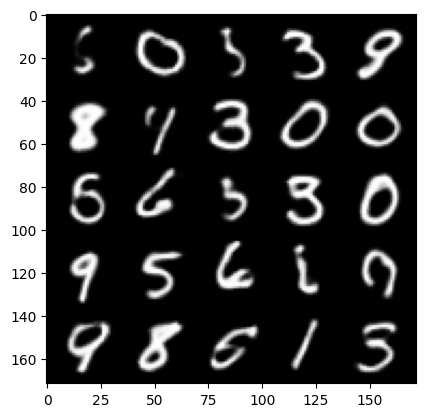

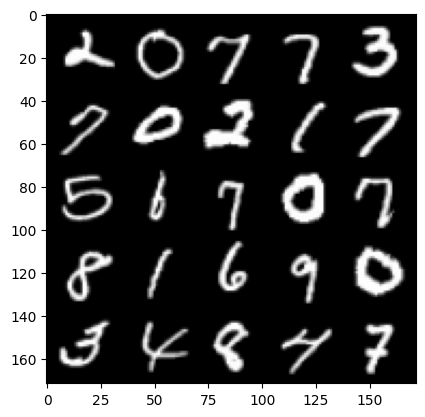

 95%|█████████▍| 890/938 [00:38<00:01, 24.17it/s]

Epoch 95, step 90000: G loss: 0.05197354926541453, dloss: 0.062435253726690974, M :0.0679892748594284,k:0.11830879860743992


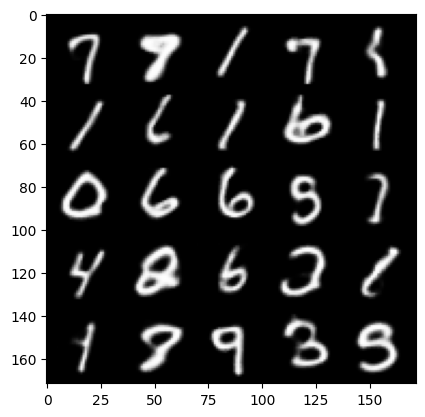

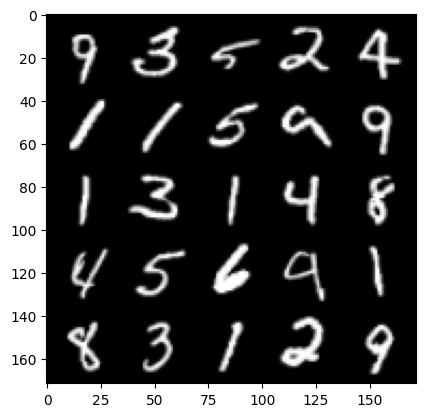

 28%|██▊       | 261/938 [00:11<00:34, 19.45it/s]

Epoch 101, step 95000: G loss: 0.052085720150172654, dloss: 0.06219170555993927, M :0.06912332773208618,k:0.11380236119404552


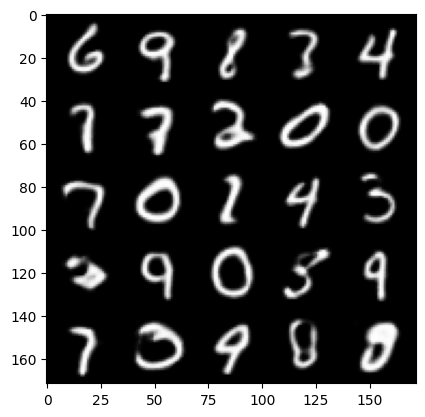

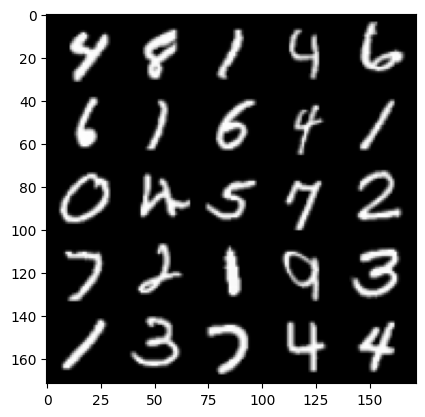

 61%|██████    | 572/938 [00:25<00:15, 23.71it/s]

Epoch 106, step 100000: G loss: 0.05242991498634217, dloss: 0.06196849485784778, M :0.08124350756406784,k:0.10565679837018341


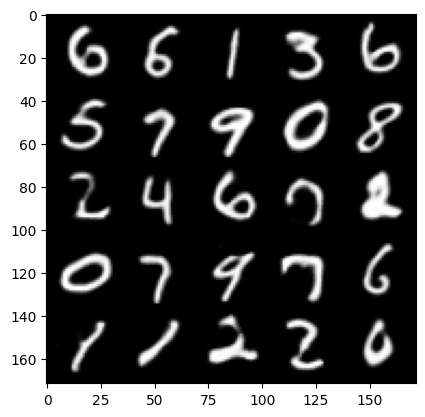

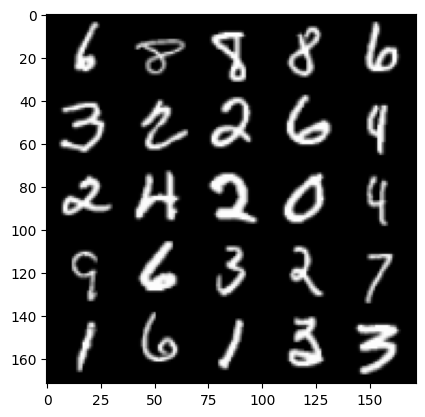

 94%|█████████▍| 880/938 [00:38<00:02, 24.35it/s]

Epoch 111, step 105000: G loss: 0.05274974990189087, dloss: 0.061976883833110466, M :0.07332291454076767,k:0.09411308613419625


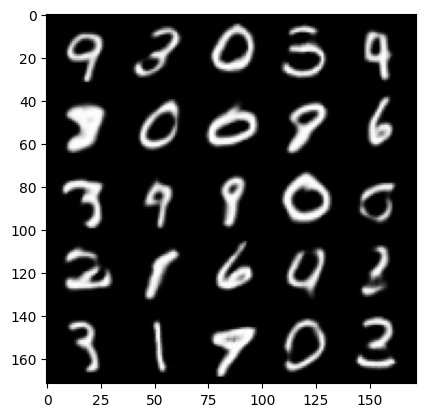

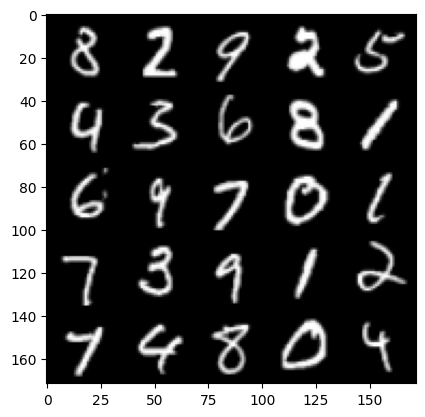

 27%|██▋       | 252/938 [00:11<00:29, 22.98it/s]

Epoch 117, step 110000: G loss: 0.05243971376121029, dloss: 0.06214537288844575, M :0.06613729894161224,k:0.08228212082013542


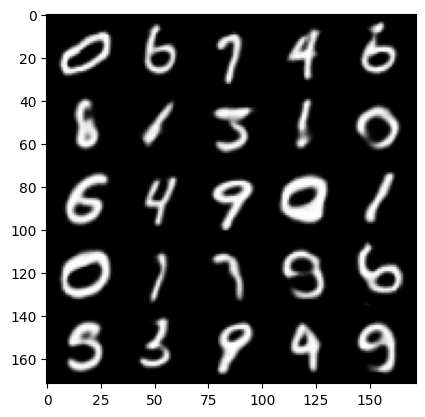

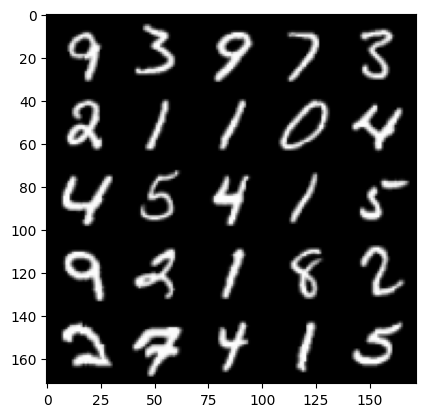

 60%|██████    | 563/938 [00:25<00:18, 19.81it/s]

Epoch 122, step 115000: G loss: 0.05141495896950354, dloss: 0.062234674964100185, M :0.06899358332157135,k:0.07356085800379555


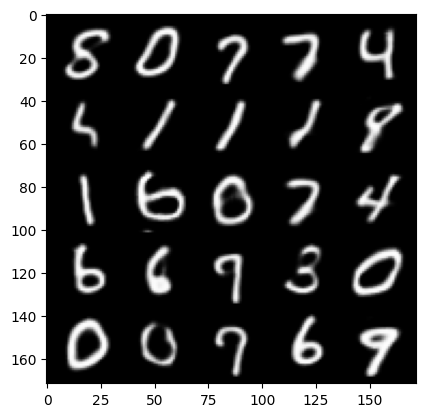

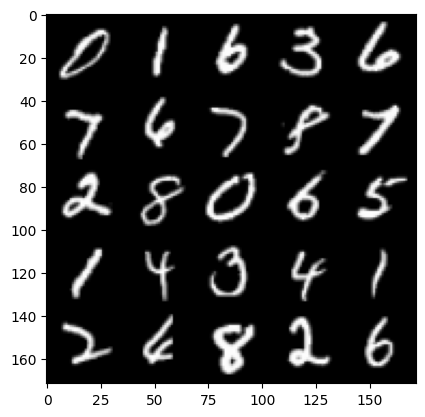

 93%|█████████▎| 872/938 [00:39<00:02, 23.24it/s]

Epoch 127, step 120000: G loss: 0.05019361248388897, dloss: 0.062158375862985685, M :0.06922981142997742,k:0.06904812942445272


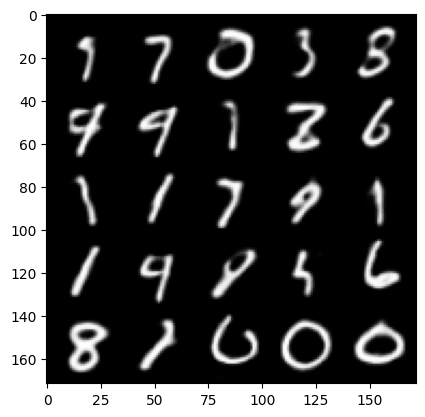

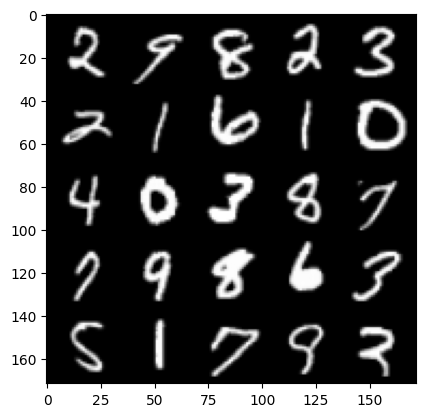

 26%|██▌       | 244/938 [00:11<00:30, 22.99it/s]

Epoch 133, step 125000: G loss: 0.04921162625029684, dloss: 0.06185701437517993, M :0.060754574835300446,k:0.0675339277833704


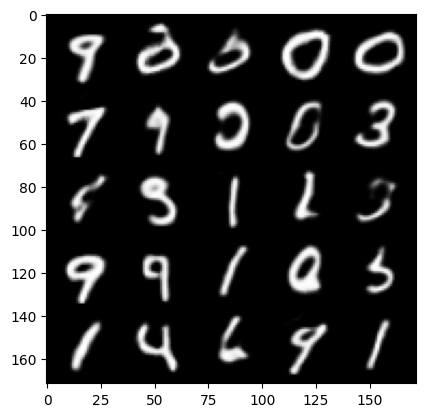

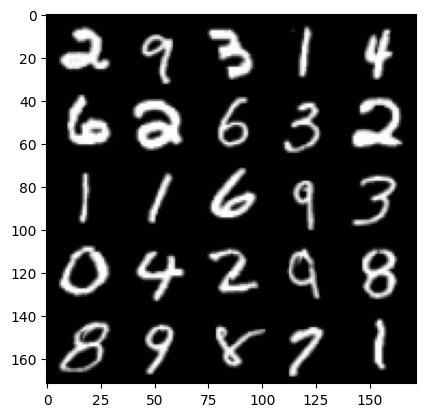

 59%|█████▉    | 554/938 [00:26<00:16, 22.83it/s]

Epoch 138, step 130000: G loss: 0.048536658854782526, dloss: 0.06157954874485748, M :0.06188402697443962,k:0.06808138716965936


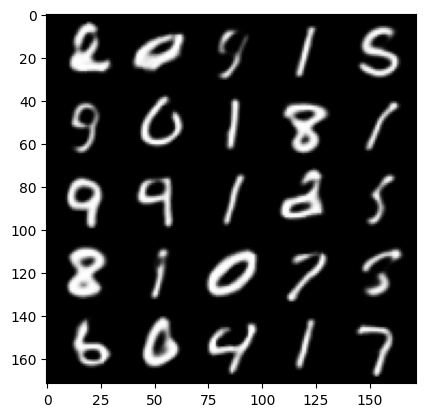

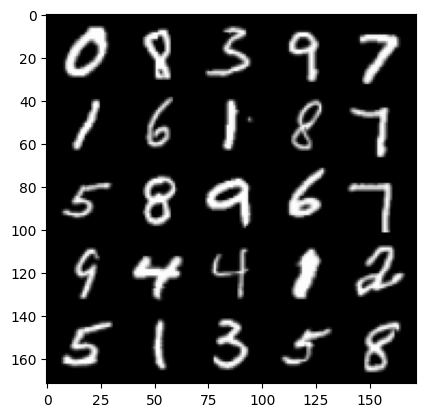

 92%|█████████▏| 866/938 [00:39<00:03, 23.01it/s]

Epoch 143, step 135000: G loss: 0.048131516225635856, dloss: 0.06120291690975423, M :0.06714815646409988,k:0.06933782599121327


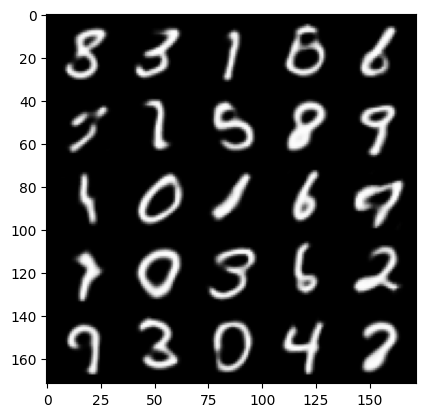

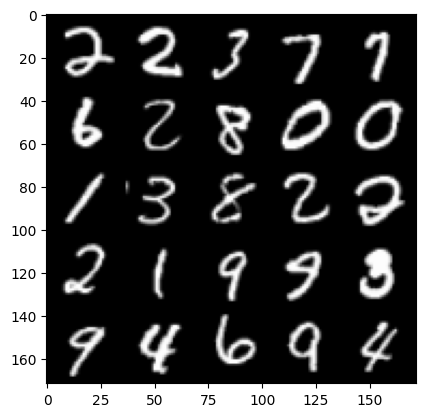

 96%|█████████▌| 901/938 [00:41<00:01, 22.80it/s]

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for i,(imgs,_) in enumerate(tqdm(dataloader)):
        real_imgs = imgs.to(device)

        #----------------
        #Train Generator
        #---------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(real_imgs.size(0),latent_dim).to(device)

        #generate a batch of images
        gen_imgs = generator(z)

        g_loss = torch.mean(torch.abs(discriminator(gen_imgs) - gen_imgs))

        g_loss.backward()
        optimizer_G.step()


        #----------------
        #Train Discriminator
        #---------------
        optimizer_D.zero_grad()

        d_real = discriminator(real_imgs)
        d_fake = discriminator(gen_imgs.detach())

        d_loss_real = torch.mean(torch.abs(d_real - real_imgs))
        d_loss_fake = torch.mean(torch.abs(d_fake - gen_imgs.detach()))

        d_loss = d_loss_real - k * d_loss_fake

        d_loss.backward()
        optimizer_D.step()

        # ----------------
        # Update weights
        # ----------------
        diff = torch.mean(gamma * d_loss_real - d_loss_fake)

        #update weight term for fake samples
        k = k +lambda_k*diff.item()
        k = min(max(k, 0), 1)  # Constraint to interval [0, 1]

        # Update convergence metric
        M = (d_loss_real + torch.abs(diff)).item()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += d_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += g_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: G loss: {mean_generator_loss}, dloss: {mean_discriminator_loss}, M :{M},k:{k}")

            show_tensor_images(gen_imgs)
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1